## Import packages

In [ ]:
!pip install lifelines;

In [ ]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from lifelines.plotting import add_at_risk_counts


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pandas.core.api import DataFrame
data = pd.read_excel("./drive/MyDrive/GDHF_Data Analysis/DOTS_Database_209.xlsx")

# Rename some columns
data.rename(columns = {"Age à l'enrollement": 'Age',
                       "Type de DOTS": "DOTS_type",
                       "Regime au debut DOTS ( IP/II)": "Regimen",
                       "Milieu": "Area",
                       "Sexe": "Sex"}, inplace = True)

# Create age range function
def age_range(age):
  if age in range(0, 5):
    return "< 5 y/o"
  elif age in range(5, 10):
    return "5 - 9 y/o"
  else:
    return "10 - 14 y/o"

# Create age range column
data['age_range'] = data['Age'].map(age_range)

# Preview
data.head(5)

,full_code,Sex,Age,DOTS_type,# of months before ending DOTS1,# of months before ending DOTS 2,Time_on_dots,Statut DOTS,Regimen,Area,age_range
0,LAT/HNDP/ST00061,F,6,Appels,6.0,NaN,6,1,IP,Rural,5 - 9 y/o
1,PIG/CSSR/ST00758,M,2,Visites,NaN,1.0,1,1,IP,Rural,< 5 y/o
2,PIG/CSSR/ST00626,F,4,Visites,NaN,6.0,6,1,IP,Rural,< 5 y/o
3,CAP/CSBL/ST00119,F,1,Visites,NaN,6.0,6,1,II,Rural,< 5 y/o
4,CAP/CSBL/ST00068,M,2,Appels puis Visites,NaN,1.0,1,1,IP,Rural,< 5 y/o


In [ ]:
data.loc[(data['Sex'] == 'F'), 'Sex'] = 'Female'
data.loc[(data['Sex'] == 'M'), 'Sex'] = 'Male'
data.loc[(data['Area'] == 'Urbain'), 'Area'] = 'Urban'
data.loc[(data['DOTS_type'] == 'Appels'), 'DOTS_type'] = 'Calls'
data.loc[(data['DOTS_type'] == 'Visites'), 'DOTS_type'] = 'Visits'
data.loc[(data['DOTS_type'] == 'Appels puis Visites'), 'DOTS_type'] = 'Calls followed by Visits'
data.loc[(data['DOTS_type'] == 'Appels + Visites'), 'DOTS_type'] = 'Calls + Visits'


## Global Survival Analysis Kaplan-Meier

Populating the interactive namespace from numpy and matplotlib


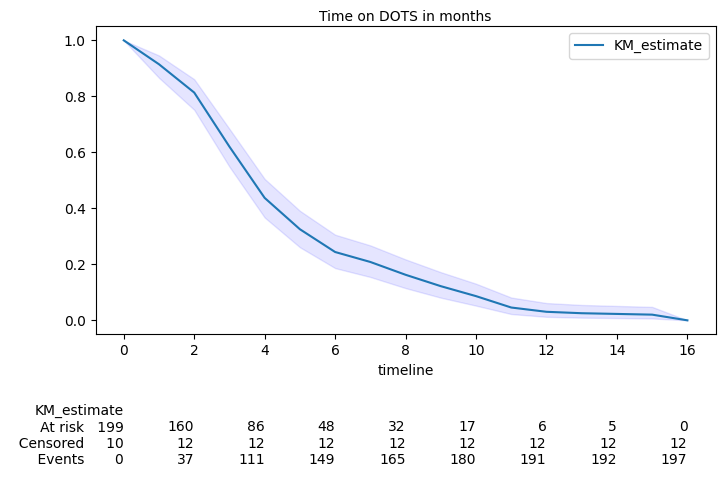

In [ ]:
# ax = subplot(111)
kmf = KaplanMeierFitter()
T = data['Time_on_dots']
C = data['Statut DOTS']
kmf.fit(T, C)

%pylab inline
figsize(8, 4)
ax = kmf.survival_function_.plot()
add_at_risk_counts(kmf, ax=ax)
ci = kmf.confidence_interval_
ax.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color='blue', alpha=0.10)
plt.xlabel('Time on DOTS in months')
plt.ylabel('Survival probability');

In [ ]:
from lifelines.utils import median_survival_times

median = kmf.median_survival_time_
median_confidence_interval = median_survival_times(kmf.confidence_interval_)
print(f"The number of months required to have at least 50% of probability for VL suppression on DOTS: {median}.")
print("Confidence interval:")
median_confidence_interval

The number of months required to have at least 50% of probability for VL suppression on DOTS: 4.0.
Confidence interval:


,KM_estimate_lower_0.95,KM_estimate_upper_0.95
0.5,4.0,5.0


## Survival Analysis by sex

<lifelines.KaplanMeierFitter:"Female", fitted with 113 total observations, 5 right-censored observations>

Text(0.5, 0, 'Time on DOTS in months')

Text(0, 0.5, 'Survival probability')

<lifelines.KaplanMeierFitter:"Male", fitted with 96 total observations, 7 right-censored observations>

Text(0.5, 0, 'Time on DOTS in months')

Text(0, 0.5, 'Survival probability')

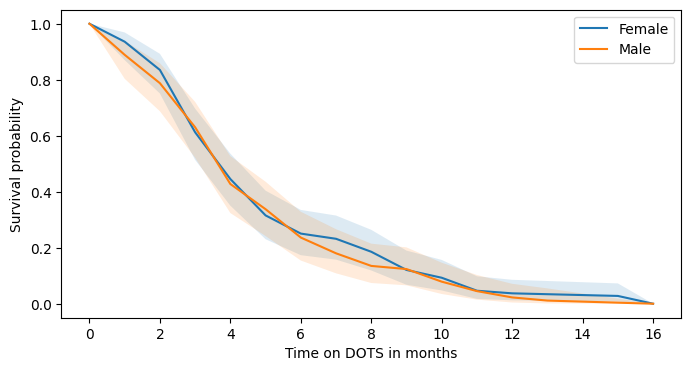

In [ ]:
ax = subplot(111)

for sex in data['Sex'].unique():
  sex_data = data[data['Sex'] == sex]
  kmf.fit(durations = sex_data['Time_on_dots'], event_observed = sex_data['Statut DOTS'], label=sex)
  ax = kmf.survival_function_.plot(ax=ax)
  ci = kmf.confidence_interval_
  ax.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], alpha=0.15)
  plt.xlabel('Time on DOTS in months')
  plt.ylabel('Survival probability');

## Survival Analysis by regimen

<lifelines.KaplanMeierFitter:"IP", fitted with 125 total observations, 5 right-censored observations>

Text(0.5, 0, 'Time on DOTS in months')

Text(0, 0.5, 'Survival probability')

<lifelines.KaplanMeierFitter:"II", fitted with 84 total observations, 7 right-censored observations>

Text(0.5, 0, 'Time on DOTS in months')

Text(0, 0.5, 'Survival probability')

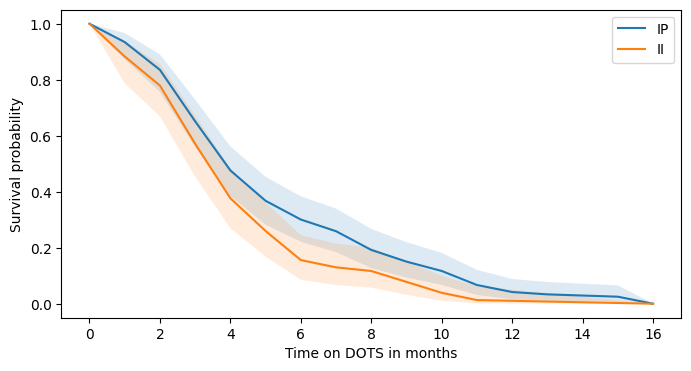

In [ ]:
ax = subplot(111)

for regim in data['Regimen'].unique():
  regim_data = data[data['Regimen'] == regim]
  kmf.fit(durations = regim_data['Time_on_dots'], event_observed = regim_data['Statut DOTS'], label = regim)
  ax = kmf.survival_function_.plot(ax=ax)
  ci = kmf.confidence_interval_
  ax.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], alpha=0.15)
  plt.xlabel('Time on DOTS in months')
  plt.ylabel('Survival probability')

### Test de Mann-Whitney - Différence de médiane - Régimes

In [ ]:
from scipy.stats import mannwhitneyu

group1 = data[data['Regimen'] == 'IP']['Time_on_dots']
group2 = data[data['Regimen'] == 'II']['Time_on_dots']

# Effectue le test de Mann-Whitney
statistic, p_value = mannwhitneyu(group1, group2)

# Affiche les résultats
print(f"Statistique U de Mann-Whitney : {statistic}")
print(f"p-value : {p_value}")

# Interprète les résultats
alpha = 0.05
if p_value < alpha:
    print("La différence est statistiquement significative entre les deux régimes. On rejette l'hypothèse nulle selon laquelle les médianes sont égales statistiquement.")
else:
    print("Il n'y a pas suffisamment de preuves pour rejeter l'hypothèse nulle.")



Statistique U de Mann-Whitney : 6212.0
p-value : 0.023835864483829933
La différence est statistiquement significative entre les deux régimes. On rejette l'hypothèse nulle selon laquelle les médianes sont égales statistiquement.


## Survival Analysis by age range

<lifelines.KaplanMeierFitter:"5 - 9 y/o", fitted with 71 total observations, 5 right-censored observations>

Text(0.5, 0, 'Time on DOTS in months')

Text(0, 0.5, 'Survival probability')

<lifelines.KaplanMeierFitter:"< 5 y/o", fitted with 88 total observations, 6 right-censored observations>

Text(0.5, 0, 'Time on DOTS in months')

Text(0, 0.5, 'Survival probability')

<lifelines.KaplanMeierFitter:"10 - 14 y/o", fitted with 50 total observations, 1 right-censored observations>

Text(0.5, 0, 'Time on DOTS in months')

Text(0, 0.5, 'Survival probability')

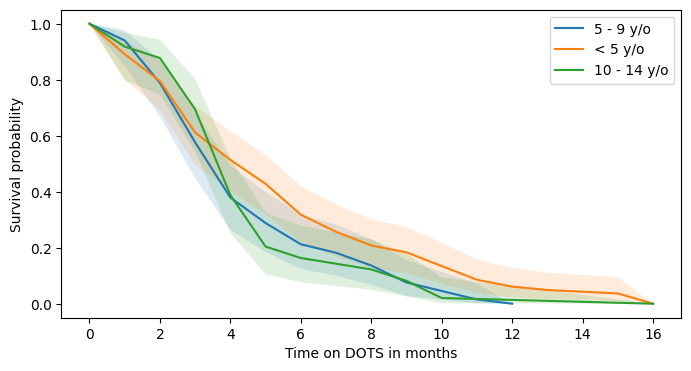

In [ ]:
ax = subplot(111)

for age in data['age_range'].unique():
  age_data = data[data['age_range'] == age]
  kmf.fit(durations = age_data['Time_on_dots'], event_observed = age_data['Statut DOTS'], label = age)
  ax = kmf.survival_function_.plot(ax=ax)
  ci = kmf.confidence_interval_
  ax.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], alpha=0.15)
  plt.xlabel('Time on DOTS in months')
  plt.ylabel('Survival probability')

## Survival Analysis by DOTS type

<lifelines.KaplanMeierFitter:"Calls", fitted with 87 total observations, 4 right-censored observations>

Text(0.5, 0, 'Time on DOTS in months')

Text(0, 0.5, 'Survival probability')

<lifelines.KaplanMeierFitter:"Visits", fitted with 86 total observations, 6 right-censored observations>

Text(0.5, 0, 'Time on DOTS in months')

Text(0, 0.5, 'Survival probability')

<lifelines.KaplanMeierFitter:"Calls followed by Visits", fitted with 25 total observations, 0 right-censored observations>

Text(0.5, 0, 'Time on DOTS in months')

Text(0, 0.5, 'Survival probability')

<lifelines.KaplanMeierFitter:"Calls + Visits", fitted with 11 total observations, 2 right-censored observations>

Text(0.5, 0, 'Time on DOTS in months')

Text(0, 0.5, 'Survival probability')

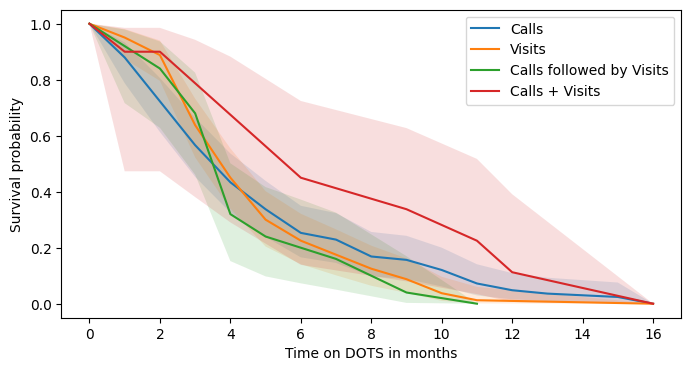

In [ ]:
ax = subplot(111)

for type in data['DOTS_type'].unique():
  type_data = data[data['DOTS_type'] == type]
  kmf.fit(durations = type_data['Time_on_dots'], event_observed = type_data['Statut DOTS'], label = type)
  ax = kmf.survival_function_.plot(ax=ax)
  ci = kmf.confidence_interval_
  ax.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], alpha=0.15)
  plt.xlabel('Time on DOTS in months')
  plt.ylabel('Survival probability')

## Survival Analysis by region

<lifelines.KaplanMeierFitter:"Rural", fitted with 93 total observations, 4 right-censored observations>

Text(0.5, 0, 'Time on DOTS in months')

Text(0, 0.5, 'Survival probability')

<lifelines.KaplanMeierFitter:"Urban", fitted with 116 total observations, 8 right-censored observations>

Text(0.5, 0, 'Time on DOTS in months')

Text(0, 0.5, 'Survival probability')

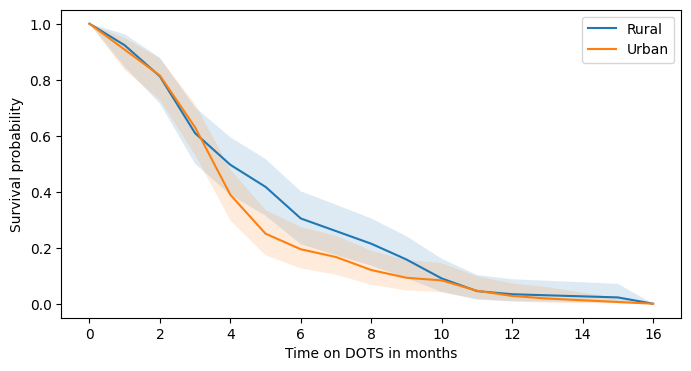

In [ ]:
ax = subplot(111)

for mil in data['Area'].unique():
  mil_data = data[data['Area'] == mil]
  kmf.fit(durations = mil_data['Time_on_dots'], event_observed = mil_data['Statut DOTS'], label = mil)
  ax = kmf.survival_function_.plot(ax=ax)
  ci = kmf.confidence_interval_
  ax.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], alpha=0.15)
  plt.xlabel('Time on DOTS in months')
  plt.ylabel('Survival probability')

In [ ]:
from scipy.stats import mannwhitneyu

group1 = data[data['Area'] == 'Rural']['Time_on_dots']
group2 = data[data['Area'] == 'Urban']['Time_on_dots']

# Effectue le test de Mann-Whitney
statistic, p_value = mannwhitneyu(group1, group2)

# Affiche les résultats
print(f"Statistique U de Mann-Whitney : {statistic}")
print(f"p-value : {p_value}")

# Interprète les résultats
alpha = 0.05
if p_value < alpha:
    print("La différence est statistiquement significative entre les deux zones de résidence. On rejette l'hypothèse nulle selon laquelle les médianes sont égales statistiquement.")
else:
    print("Il n'y a pas suffisamment de preuves pour rejeter l'hypothèse nulle qui implique une différence non significative entre les médianes des groupes.")

Statistique U de Mann-Whitney : 5991.0
p-value : 0.16663912665826397
Il n'y a pas suffisamment de preuves pour rejeter l'hypothèse nulle qui implique une différence non significative entre les médianes des groupes.


## **Distribution analysis of time to undetectability**

In [ ]:
data_ind = data[data['Time_on_dots'] > 0]

### Global distribution of time to undetectability

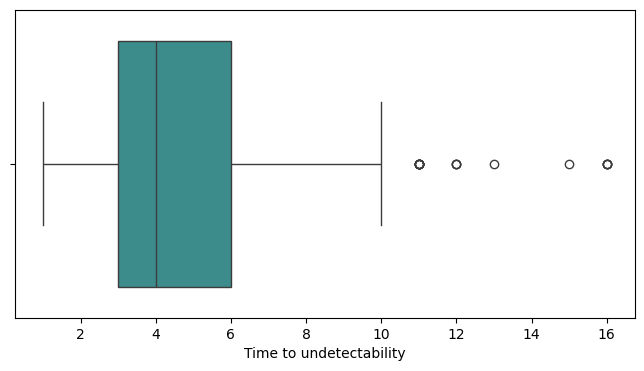

In [ ]:
color = ['#309999']
sns.boxplot(x='Time_on_dots', data=data_ind, palette = color)
plt.xlabel("Time to undetectability");

### Distribution of time to undetectability by factors

In [ ]:
# data.to_excel("Data_GDHF.xlsx", index = False)

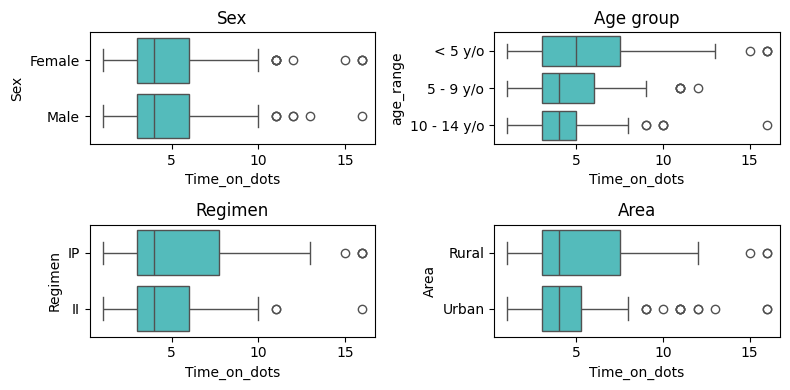

In [ ]:
num_rows = 2
num_cols = 2

order = ['< 5 y/o', '5 - 9 y/o', '10 - 14 y/o']

# Créer la grille de graphiques avec une boucle for
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 4))

# Aplatir les axes pour itérer plus facilement
axes = axes.flatten()

df = data_ind[['Sex', 'age_range', 'Regimen', 'Area']]
for i, variable in enumerate(df.columns):
    # Créer le boxplot
    if variable == 'age_range':
        sns.boxplot(y=df['age_range'], x=data_ind['Time_on_dots'], ax=axes[i], order=order, color='#43CCCC')
        axes[i].set_title('Age group')
    else:
        sns.boxplot(y=df[variable], x=data_ind['Time_on_dots'], ax=axes[i], color='#43CCCC')
        axes[i].set_title(variable)

# Ajuster la disposition pour éviter les chevauchements
plt.tight_layout()

# Afficher les boxplots
plt.show();